<a href="https://colab.research.google.com/github/athulv2001/autonomous-motion-prediction-cnn-rf/blob/main/Predicting_Autonomous_Vechiles_Motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, roc_curve, ConfusionMatrixDisplay
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
import matplotlib.pyplot as plt
from scipy.stats import randint

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load dataset
data_path = '/content/drive/My Drive/lyft-motion-prediction-autonomous-vehicles/lyft_motion_prediction.csv'
data = pd.read_csv(data_path)

In [6]:
# Data Preprocessing
#Missing Values: The code removes rows with missing values using dropna().

data = data.dropna()


In [7]:
#Feature and Target Selection: The features and target variables are extracted from the dataset.

features = data[['centroid_x', 'centroid_y', 'extent_x', 'extent_y', 'extent_z', 'yaw', 'velocity_x', 'velocity_y']]
target = data[['label_probabilities_PERCEPTION_LABEL_CAR', 'label_probabilities_PERCEPTION_LABEL_CYCLIST', 'label_probabilities_PERCEPTION_LABEL_PEDESTRIAN']].idxmax(axis=1)


In [8]:
#Outlier Handling: The Z-score is used to detect and remove outliers, with a threshold of 3.

z = np.abs(stats.zscore(features))
threshold = 3
filtered_entries = (z < threshold).all(axis=1)
features_filtered = features[filtered_entries]
target_filtered = target[filtered_entries]


In [9]:
#Feature Normalization: The StandardScaler is used to normalize the features for better model convergence.

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_filtered)


In [10]:
# Dimensionality Reduction
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(pca_features, target_filtered, test_size=0.3, random_state=42)

In [12]:
#To reduce the dataset size, a function downsample_data() randomly selects a fraction (e.g., 10%) of the data for training and evaluation.

def downsample_data(X, y, fraction=0.1):
    indices = np.random.choice(X.shape[0], int(X.shape[0] * fraction), replace=False)
    return X[indices], y[indices]

In [13]:
#Create Sequences for CNN
#A function create_sequences() is used to convert data into sequences of 5 steps (time-series-like data) for the CNN. The sequence length is a critical parameter for feeding into the CNN.

def create_sequences(data, labels, seq_length=5):
    X, y = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X.append(data[i:i + seq_length])
        y.append(labels.iloc[i + seq_length])
    return np.array(X), np.array(y)

# Create sequences
X_seq, y_seq = create_sequences(scaled_features, target_filtered, seq_length=5)

# Downsample the sequences
X_seq, y_seq = downsample_data(X_seq, y_seq, fraction=0.1)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

# Convert y_train_seq and y_test_seq to numeric
y_train_seq = pd.factorize(y_train_seq)[0]
y_test_seq = pd.factorize(y_test_seq)[0]

# Create sequences
X_seq, y_seq = create_sequences(scaled_features, target_filtered, seq_length=5)

# Downsample the sequences if necessary
X_seq, y_seq = downsample_data(X_seq, y_seq, fraction=0.1)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

# Convert y_train_seq and y_test_seq to numeric
y_train_seq = pd.factorize(y_train_seq)[0]
y_test_seq = pd.factorize(y_test_seq)[0]

# Clear previous session to free memory
from tensorflow.keras import backend as K
K.clear_session()

In [14]:
#Building and Training the CNN
#Input Layer: Accepts a sequence of 5 timesteps with 3 features per timestep.
#Convolutional Layer: Applies 1D convolution with 64 filters.
#MaxPooling Layer: Reduces the size of feature maps.
#Dropout Layers: Prevents overfitting by randomly turning off neurons during training.
#Dense Layers: Fully connected layers with 128 neurons and 1 output neuron.
#Compilation: The model uses adam optimizer and binary_crossentropy as the loss function for binary classification.

cnn_model = Sequential([
    Input(shape=(5, X_train_seq.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=16, validation_split=0.2)
cnn_model.summary()

Epoch 1/10
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9664 - loss: 0.1804 - val_accuracy: 0.9687 - val_loss: 0.1605
Epoch 2/10
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9689 - loss: 0.1608 - val_accuracy: 0.9687 - val_loss: 0.1593
Epoch 3/10
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9684 - loss: 0.1616 - val_accuracy: 0.9687 - val_loss: 0.1584
Epoch 4/10
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9693 - loss: 0.1569 - val_accuracy: 0.9687 - val_loss: 0.1584
Epoch 5/10
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9682 - loss: 0.1604 - val_accuracy: 0.9687 - val_loss: 0.1582
Epoch 6/10
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9693 - loss: 0.1547 - val_accuracy: 0.9687 - val_loss: 0.1590
Epoch 7/10
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9681 - loss: 0.1604 - val_accuracy: 0.9687 - val_loss: 0.1582
Epoch 8/10
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9685 - loss: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 64)          │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,149 (117.77 KB)

 Trainable params: 10,049 (39.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,100 (78.52 KB)

1713/1713 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
CNN Model Evaluation Metrics:
F1 Score:  0.9536582098657103
Precision:  0.9388489338197309
Recall:  0.9689421725880915

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     53099
           1       0.00      0.00      0.00      1372
           2       0.00      0.00      0.00       330

    accuracy                           0.97     54801
   macro avg       0.32      0.33      0.33     54801
weighted avg       0.94      0.97      0.95     54801



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

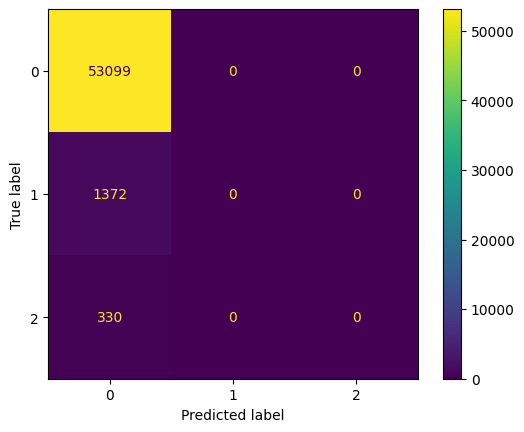

In [15]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Make predictions using your CNN model
cnn_predictions = cnn_model.predict(X_test_seq)
cnn_predictions = (cnn_predictions > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Evaluate the CNN model
print("CNN Model Evaluation Metrics:")
print("F1 Score: ", f1_score(y_test_seq, cnn_predictions, average='weighted'))
print("Precision: ", precision_score(y_test_seq, cnn_predictions, average='weighted'))
print("Recall: ", recall_score(y_test_seq, cnn_predictions, average='weighted'))

# Get a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_seq, cnn_predictions))

# Confusion Matrix (Optional)
conf_matrix = confusion_matrix(y_test_seq, cnn_predictions)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()


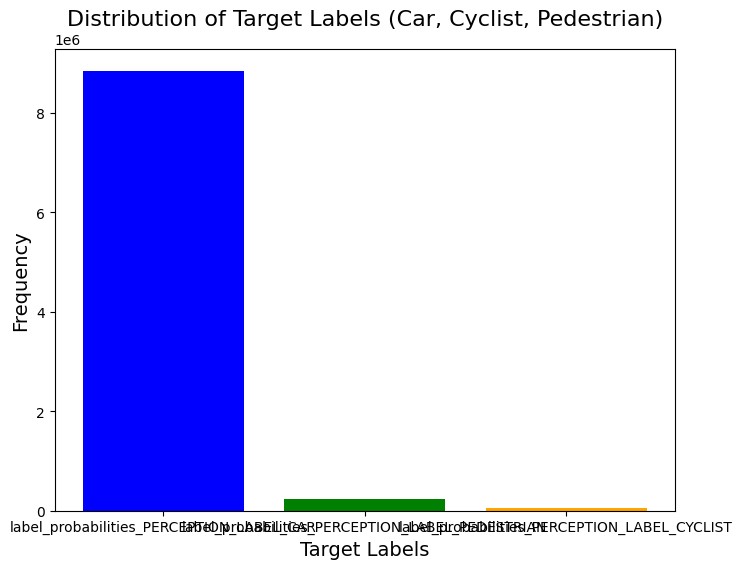

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'target_filtered' contains the target labels from your project
# Example target labels:
# target_filtered = pd.Series(['car', 'cyclist', 'pedestrian', 'car', ...])

# Count the occurrences of each label (car, cyclist, pedestrian)
label_counts = target_filtered.value_counts()

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'green', 'orange'])

# Add title and labels
plt.title('Distribution of Target Labels (Car, Cyclist, Pedestrian)', fontsize=16)
plt.xlabel('Target Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

Random Forest Model Evaluation Metrics:
F1 Score:  0.9563069421378073
Precision:  0.9674520728938629
Recall:  0.9699275560664952

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     53099
           1       0.86      0.04      0.07      1372
           2       1.00      0.04      0.08       330

    accuracy                           0.97     54801
   macro avg       0.94      0.36      0.38     54801
weighted avg       0.97      0.97      0.96     54801



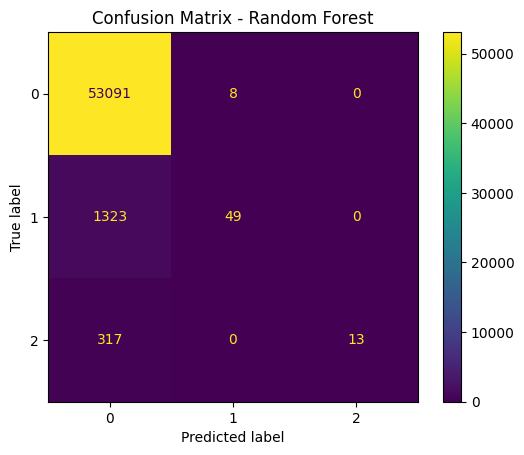

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Random Forest Classifier
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model on the training set
rf_model.fit(X_train_seq.reshape(X_train_seq.shape[0], -1), y_train_seq)  # Flatten the sequence data

# Make predictions on the test set using Random Forest
rf_predictions = rf_model.predict(X_test_seq.reshape(X_test_seq.shape[0], -1))

# Evaluate the Random Forest model
print("Random Forest Model Evaluation Metrics:")

# Calculate the F1 Score, Precision, and Recall
print("F1 Score: ", f1_score(y_test_seq, rf_predictions, average='weighted'))
print("Precision: ", precision_score(y_test_seq, rf_predictions, average='weighted'))
print("Recall: ", recall_score(y_test_seq, rf_predictions, average='weighted'))

# Get a detailed classification report
print("\nClassification Report for Random Forest:")
print(classification_report(y_test_seq, rf_predictions))

# 2. Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test_seq, rf_predictions)
ConfusionMatrixDisplay(conf_matrix_rf).plot()
plt.title('Confusion Matrix - Random Forest')
plt.show()
